In [4]:
%load_ext autoreload
%autoreload 2

# Demand forecast using tensorflow

Tensorflow recently released Tensorflow 2.0! It is still in public beta phase, therefore documentation and user-examples are more scarce than usual.

Why tensorflow?
Tensorflow includes tensorflow_probability, a framework for probabilistic modelling using Tensorflow which can be extended to time-series analysis.

## Source blog

Code mostly based on this blog https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083

Written by part of the Tensorflow Probability team who wrote the Structural Time Series module with easy-to-adapt code! 

# Setup python environment



In [5]:
# install nightly tensorflow build

# !pip install --upgrade tf-nightly tfp-nightly
# !pip install tensorflow==2.0.0-beta1 

## Load libraries

We will be relying on Tensorflow and Tensorflow-probability

In [8]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

import pandas as pd

In [9]:
# plot settings
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [10]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

## Load data

We exported the data from DataBricks after running all the required notebooks that produce the train/test data.

In [99]:
# Load data
df_train = pd.read_csv("../data/databricks/train_norders_export_20082019.csv")
df_forecast = pd.read_csv("../data/databricks/forecast_norders_export_20082019.csv")

# Sort properly by date
df_train = df_train.sort_values('date_delivery')
df_forecast = df_forecast.sort_values('date_delivery')


df = df_train.query("FSKU=='1384PA0'")
df.date_delivery = pd.to_datetime(df_train.date_delivery)

# Take first differences of Norders(?)
# df.Norders = [np.nan] + (df.Norders[1:].values - df.Norders[:-1].values).tolist()



C:\anaconda3\envs\demand\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Split train / test data

In [100]:
N_WEEKS_AHEAD = 12
num_forecast_steps = N_WEEKS_AHEAD * 7

df_train = df.iloc[:-num_forecast_steps,]
df_test = df.iloc[-num_forecast_steps:,]

In [101]:
df_holidays = np.array(df[["Zomervakantie", "Meivakantie",
  "Herfsvakantie", "Voorjaarsvakantie", "Kerstvakantie", ]],
                      dtype='float64')

df_promos = np.array(df[["Promo_EO", "Promo", "MOV"]], dtype='float64')

In [102]:
df_train.head()

,date_delivery,Nieuwjaarsdag,Paasdag,Koningsdag,Hemelvaartsdag,Pinksterdag,Kerstdag,Zomervakantie,Meivakantie,Herfsvakantie,...,Promo,delo_number,delo_name,Shift,PUP,FSKU,SOpen,Capacity,MOV,HMCAP
730,2017-08-19,0,0,0,0,0,0,1,0,0,...,0,1384,HSC De Meern,PA,0,1384PA0,1,1569,70,1745
729,2017-08-20,0,0,0,0,0,0,1,0,0,...,0,1384,HSC De Meern,PA,0,1384PA0,0,0,70,0
728,2017-08-21,0,0,0,0,0,0,0,0,0,...,0,1384,HSC De Meern,PA,0,1384PA0,1,1689,70,1763
727,2017-08-22,0,0,0,0,0,0,0,0,0,...,0,1384,HSC De Meern,PA,0,1384PA0,1,1810,70,1810
726,2017-08-23,0,0,0,0,0,0,0,0,0,...,0,1384,HSC De Meern,PA,0,1384PA0,1,1803,70,1740


In [103]:
# Masked time-series where we flag zero-demand days as missing so that they don't affect our model
def to_masked_timeseries(ts):
    observed_time_series = tfp.sts.MaskedTimeSeries(
      time_series=ts,
      is_missing=np.equal(ts, 0)
    )
    return(observed_time_series)

    

y = np.array(df.Norders, dtype='float64')
y_train = np.array(df_train.Norders, dtype='float64')
y_test = np.array(df_test.Norders, dtype='float64')

observed_time_series = tfp.sts.MaskedTimeSeries(
  time_series=y,
  is_missing=np.equal(y, 0)
)

y = to_masked_timeseries(y)
y_train = to_masked_timeseries(y_train)
y_test = to_masked_timeseries(y_test)

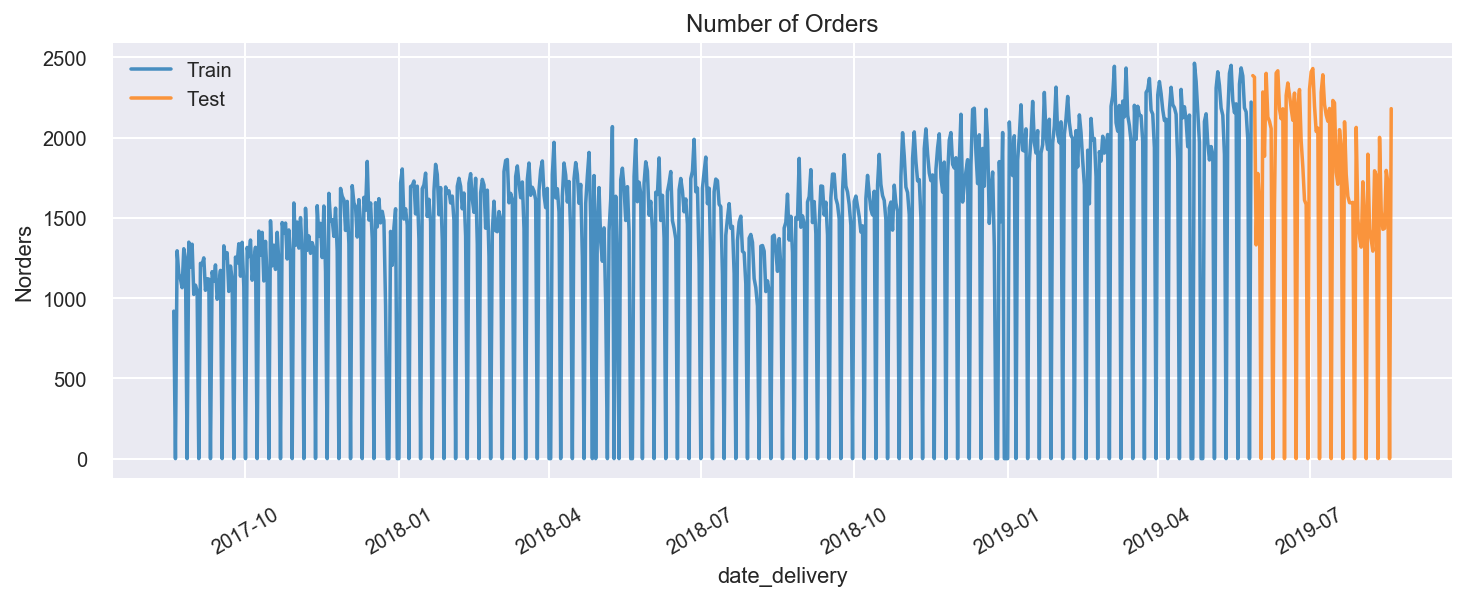

In [104]:
plt.figure(figsize=(12, 4))

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

sns.lineplot(data=df_train, 
             x="date_delivery", y="Norders",
             color=c1, alpha=0.8, label="Train")
sns.lineplot(data=df_test, 
             x="date_delivery", y="Norders",
             color=c2, alpha=0.8, label="Test")

plt.title("Number of Orders")
plt.xticks(rotation=30)
plt.legend()
print()

# Pandas profiling

Create a quick overview of the training data using `pandas-profiling` 

**Right click the 'Pandas Profiling Report' title and open in new browser tab for full screen view**

In [105]:
from pandas_profiling import ProfileReport
ProfileReport(df_train)
# ProfileReport(df_test)

C:\anaconda3\envs\demand\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


# Build a simple STS model

Structural Time Series only including,

- Local Linear Trend
- Seasonal weekly effect with 7-day seasonality

In [106]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal_week = tfp.sts.Seasonal(
      num_seasons=7, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal_week], observed_time_series=observed_time_series)

  return model

In [107]:
tf.reset_default_graph()
linear_weekly_model = build_model(y_train)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      linear_weekly_model,
      observed_time_series=y_train)

W0821 11:06:06.579401 19828 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [108]:
 # Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 201 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  # Draw samples from the variational posterior.
  q_samples_linear_weekly_ = sess.run({k: q.sample(50)
                             for k, q in variational_posteriors.items()})

step 0 -ELBO 4151.678110365055
step 20 -ELBO 3766.260672285166
step 40 -ELBO 3600.596746367465
step 60 -ELBO 3493.943892574852
step 80 -ELBO 3464.2221526681487
step 100 -ELBO 3450.547628890705
step 120 -ELBO 3450.0933535181157
step 140 -ELBO 3439.1004853214686
step 160 -ELBO 3437.531933374622
step 180 -ELBO 3438.642344132384
step 200 -ELBO 3430.740304104642


In [109]:
print("Inferred parameters:")
for param in linear_weekly_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_linear_weekly_[param.name], axis=0),
                              np.std(q_samples_linear_weekly_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 79.78061842311661 +- 4.053638174473158
LocalLinearTrend/_level_scale: 36.86827059722037 +- 4.204090290602574
LocalLinearTrend/_slope_scale: 1.2525946783393986 +- 0.47929347946510925
Seasonal/_drift_scale: 34.20168321115535 +- 2.9160183131301967


# Create forecast

We create forecasts by creating forecasts about the expected distribution of demand for future days.

Therefore our model forecast output is a statistical distribution object

In [110]:
linear_weekly_forecast_dist = tfp.sts.forecast(
    linear_weekly_model,
    observed_time_series=y_train,
    parameter_samples=q_samples_linear_weekly_,
    num_steps_forecast=num_forecast_steps)

In [111]:
num_samples=10

with tf.Session() as sess:
  linear_weekly_forecast_mean, linear_weekly_forecast_scale, linear_weekly_forecast_samples = sess.run(
      (linear_weekly_forecast_dist.mean()[..., 0],
       linear_weekly_forecast_dist.stddev()[..., 0],
       linear_weekly_forecast_dist.sample(num_samples)[..., 0]))

In [112]:
linear_weekly_dates = np.array(df.date_delivery)

In [113]:
linear_weekly_forecast_samples.shape

(10, 84)

In [114]:
max(df_train.date_delivery)
# max(df_test.date_delivery)

Timestamp('2019-05-27 00:00:00')

In [115]:
linear_weekly_dates = np.array(df_test.date_delivery)
linear_weekly_loc = mdates.MonthLocator(3)
linear_weekly_fmt = mdates.DateFormatter('%Y-%M-%d')

In [116]:
len(linear_weekly_dates)

84

# Visualize forecast

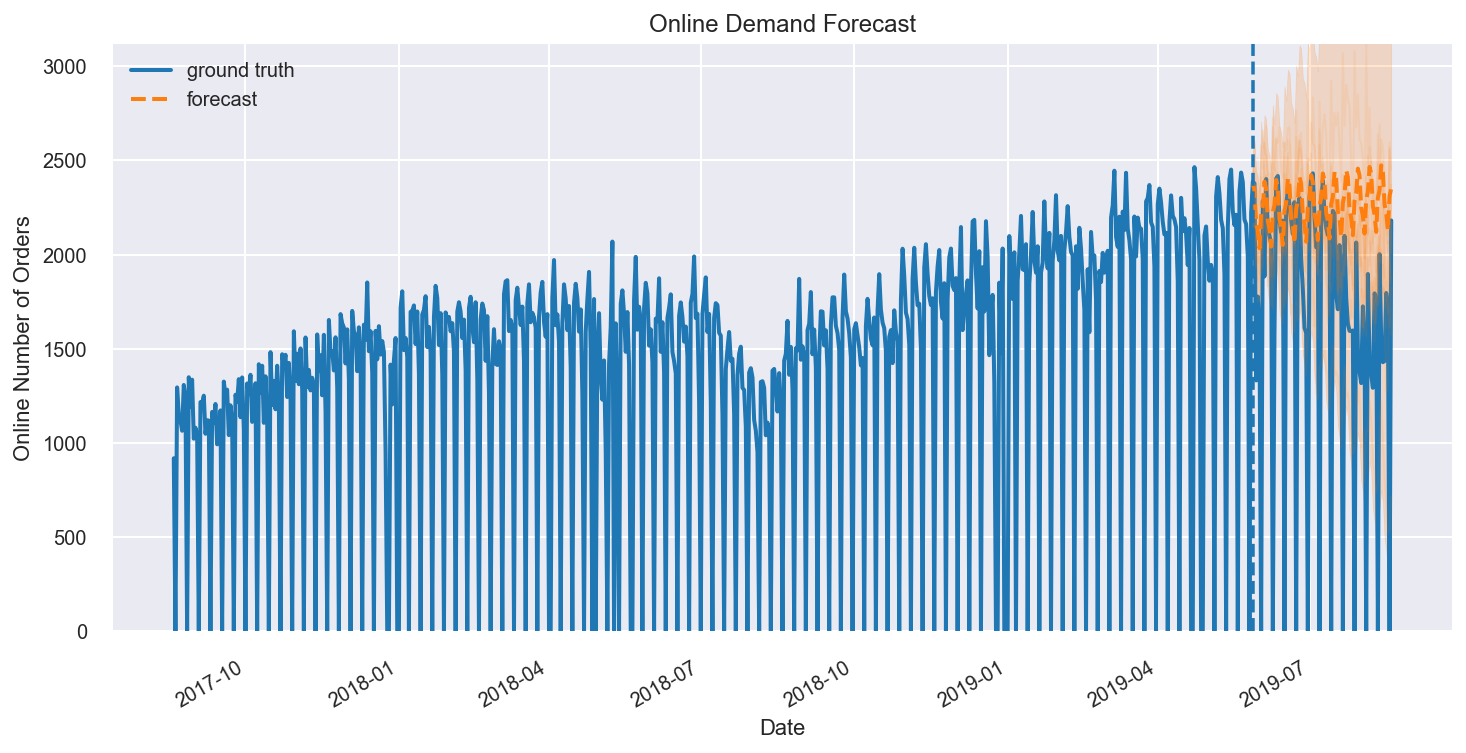

In [117]:
# Plot all points of training + test set with forecast 
x = np.array(df.sort_values('date_delivery').date_delivery, dtype="datetime64[D]")

fig, ax = plot_forecast(
    x, y.time_series,
    linear_weekly_forecast_mean, linear_weekly_forecast_scale, linear_weekly_forecast_samples,
    x_locator=None,
    x_formatter=None,
    title="Online Demand Forecast")
ax.axvline(linear_weekly_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Online Number of Orders")
ax.set_ylim((0, np.max(linear_weekly_forecast_samples)))
ax.set_xlabel("Date")
fig.autofmt_xdate()

We completely miss the holiday effect that causes the large dip, which happens during the forecasting period.

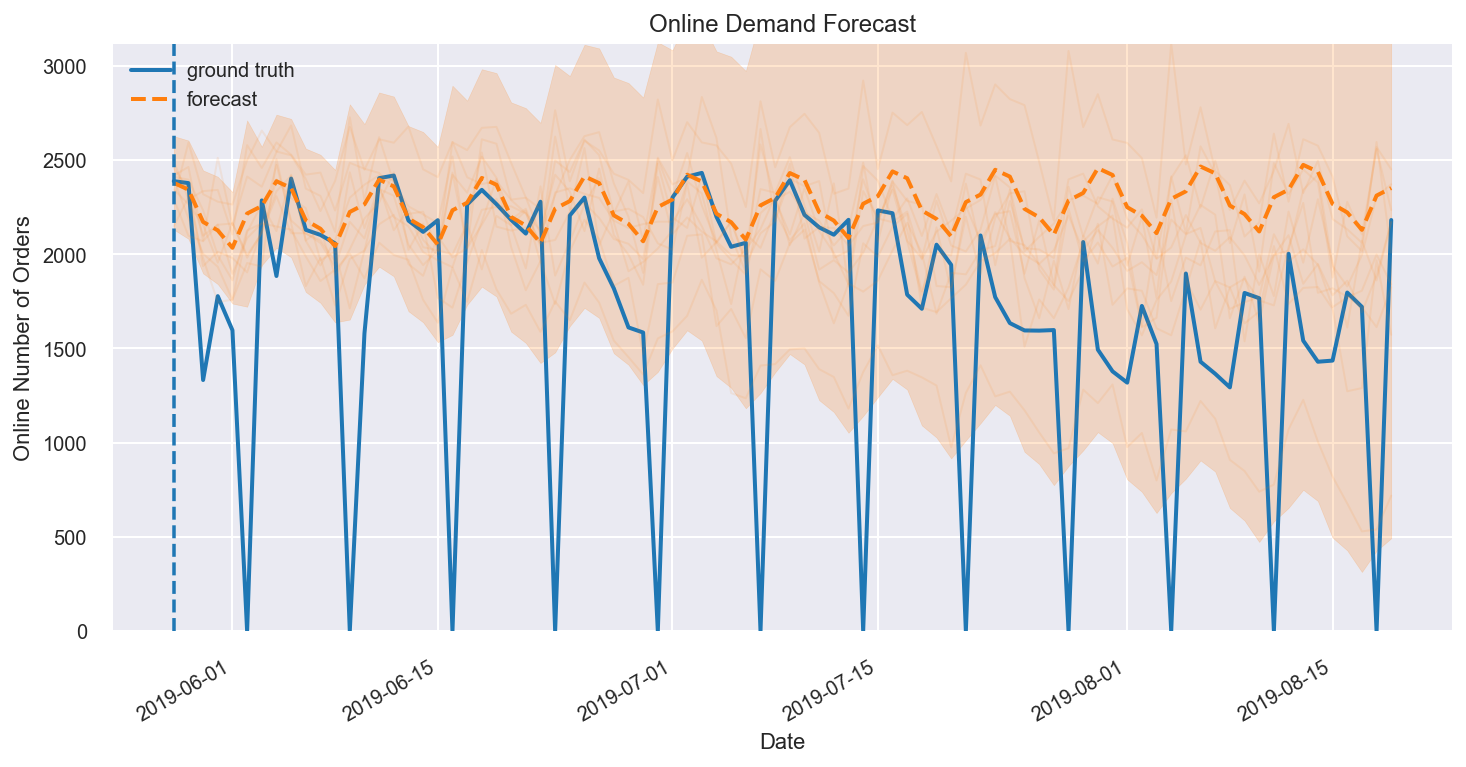

In [118]:

fig, ax = plot_forecast(
    x[-y_test.time_series.shape[0]:], y_test.time_series,
    linear_weekly_forecast_mean, linear_weekly_forecast_scale, linear_weekly_forecast_samples,
    x_locator=None,
    x_formatter=None,
    title="Online Demand Forecast")
ax.axvline(linear_weekly_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Online Number of Orders")
ax.set_ylim((0, np.max(linear_weekly_forecast_samples)))
ax.set_xlabel("Date")
fig.autofmt_xdate()

# Model component decomposition

We can visualize the predicted effects of each model component

- Local Linear Trend
- Weekly Seasonal effect

In [119]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(
    linear_weekly_model,
    observed_time_series=y,
    parameter_samples=q_samples_linear_weekly_)

In [120]:
with tf.Session() as sess:
  linear_weekly_component_means_, linear_weekly_component_stddevs_ = sess.run(
      [{k.name: c.mean() for k, c in component_dists.items()},
       {k.name: c.stddev() for k, c in component_dists.items()}])

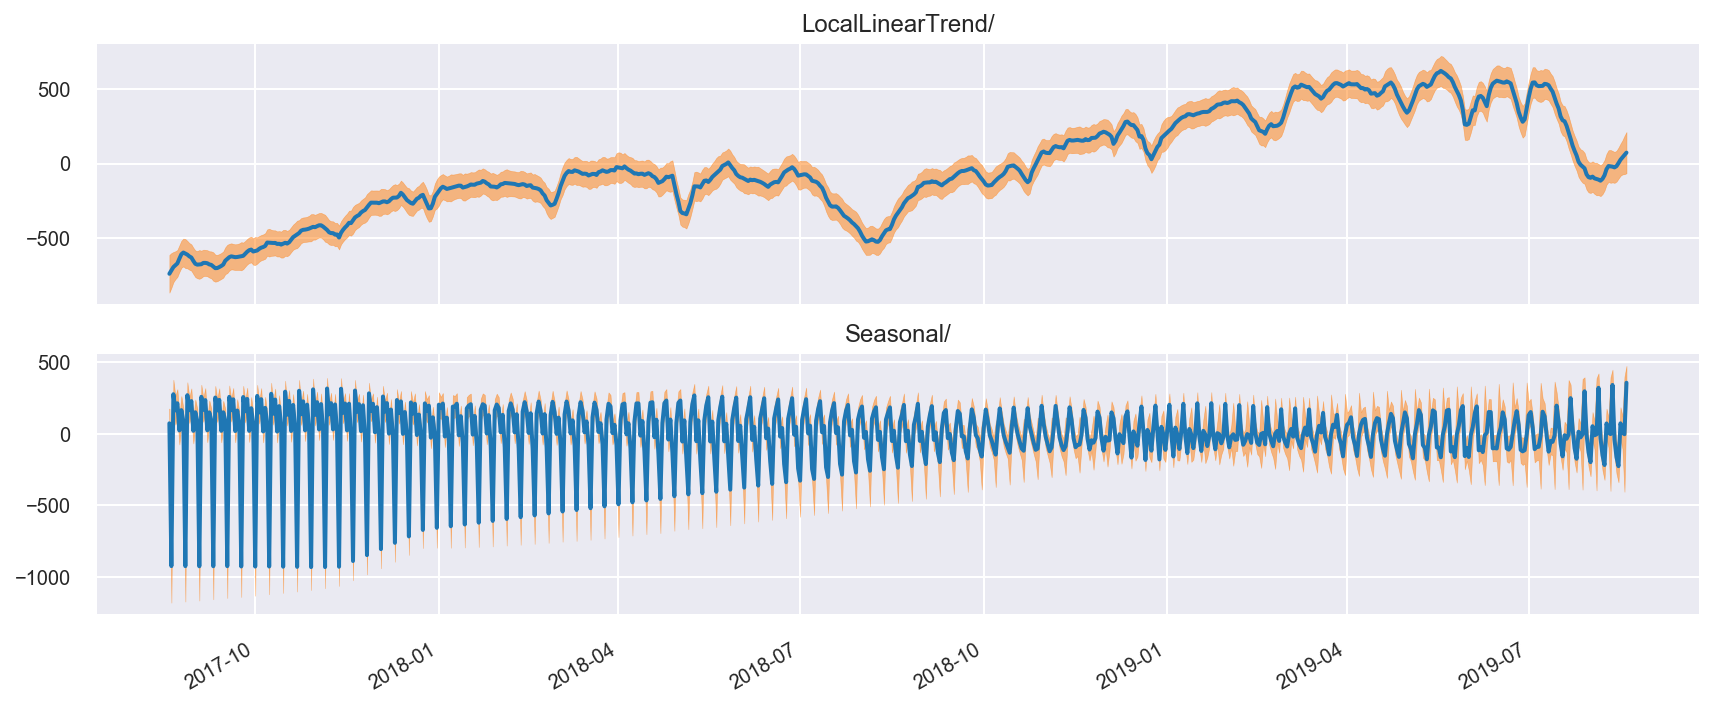

In [121]:
_ = plot_components(x, linear_weekly_component_means_, linear_weekly_component_stddevs_,
                    x_locator=None, x_formatter=None)

In [122]:
# Plot only the forecast period
x = np.array(df.date_delivery, dtype="datetime64[D]")

month_num, month_count = np.unique([str(m.year)+('0'+str(m.month))[-2:] for m in x.tolist()], return_counts=True)

# Prepare monthly effect

If we define the actual number of days  per month we can model seasonal within-month effects without having to rely on estimating monthly periods with a static number of days.

In [126]:
month_count

array([13, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 19], dtype=int64)

In [127]:
num_days_per_month = np.array(
  [[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31], # 2017
   [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],  # 2018
   [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31], # 2019
   [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31]]) # 2020 - leapyear!

In [128]:
num_days_per_season = np.array([
    [month_count[1]] + num_days_per_month.flatten()[7:18].tolist(),
    num_days_per_month.flatten()[18:30].tolist(),
    num_days_per_month.flatten()[30:42]
])

# Extend Structural Time Series model with external regressors

In [129]:


def build_model(observed_time_series, store_open):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    
  day_of_week_effect = tfp.sts.Seasonal(
      num_seasons=7, num_steps_per_season=1,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')

  month_of_year_effect = tfp.sts.Seasonal(
      num_seasons=12,
      num_steps_per_season=num_days_per_season,
      observed_time_series=observed_time_series,
      name="month_of_year_effect")
    
  store_open_effect = sts.LinearRegression(
      design_matrix=tf.reshape(np.array(df.SOpen, dtype='float64'), (-1, 1)),
      name='store_open_effect')

  promo_effect = sts.LinearRegression(
      design_matrix=df_promos,
      name='promo_effect')
    
  holiday_effect = sts.LinearRegression(
      design_matrix=df_holidays,
      name='holiday_effect')

  autoregressive = sts.Autoregressive(
      order=7,
      observed_time_series=observed_time_series, 
      name='autoregressive')
    
  model = sts.Sum([trend,
                   day_of_week_effect,
                   store_open_effect,
                   promo_effect,
                   holiday_effect,
                   month_of_year_effect,
                   autoregressive],
                   observed_time_series=observed_time_series)
  return model

In [130]:
len(np.array(df.SOpen, dtype='float64'))

731

In [131]:
tf.reset_default_graph()
demand_model = build_model(y_train, np.array(df.SOpen, dtype='float64'))

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      demand_model, y_train)
train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)

W0821 11:08:16.825901 19828 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).
W0821 11:08:16.941905 19828 linear_operator.py:940] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [38]:
# samples, kernel_results = tfp.sts.fit_with_hmc(demand_model, y_train)

C:\anaconda3\envs\demand\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [ ]:
# with tf.Session() as sess:
#   sess.run(tf.global_variables_initializer())
#   samples_, kernel_results_ = sess.run((samples, kernel_results))

In [132]:
# Run the optimization and draw samples from the surrogate posteriors.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 201  # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  q_samples_demand_ = sess.run({k: q.sample(50)
                                for k, q in variational_posteriors.items()})

step 0 -ELBO 4678.442346502811
step 20 -ELBO 3924.971406046072
step 40 -ELBO 3606.4456211407987
step 60 -ELBO 3546.97863707354
step 80 -ELBO 3509.716982270295
step 100 -ELBO 3496.4623258530196
step 120 -ELBO 3491.579725989297
step 140 -ELBO 3480.6270730109995
step 160 -ELBO 3485.1981698063223
step 180 -ELBO 3473.679810931613
step 200 -ELBO 3481.5424040132098


In [134]:
print("Inferred parameters:")
for param in demand_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 5.071219097677173 +- 2.912355988415093
LocalLinearTrend/_level_scale: 14.20821480291457 +- 7.035088932903375
LocalLinearTrend/_slope_scale: 0.8563508071171345 +- 0.35019524524407386
day_of_week_effect/_drift_scale: 34.420910375256845 +- 3.0064601385678555
store_open_effect/_weights: [0.65954414] +- [6.37783176]
promo_effect/_weights: [12.79328787 10.2794965   0.82313604] +- [6.53182186 5.58928207 1.66583452]
holiday_effect/_weights: [-0.76728055 -5.92857943 -4.34938073 -8.19252    -2.61495091] +- [6.50868865 7.34405258 5.77840645 6.37289898 7.05969637]
month_of_year_effect/_drift_scale: 2.0882044084942724 +- 3.9056420728382353
autoregressive/_coefficients: [ 0.33628205  0.08667085  0.21110752  0.03433708 -0.19602128  0.00343953
  0.04169007] +- [0.06367317 0.06695689 0.03644121 0.06147893 0.04050826 0.06657575
 0.03790018]
autoregressive/_level_scale: 94.17205387006403 +- 2.8807950565600384


# Create forecast

## Extract samples of parameter from predicted distribution

In [135]:
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=y_train,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps)

In [136]:
num_samples=10

with tf.Session() as sess:
  (demand_forecast_mean,
   demand_forecast_scale,
   demand_forecast_samples) = sess.run(
      (demand_forecast_dist.mean()[..., 0],
       demand_forecast_dist.stddev()[..., 0],
       demand_forecast_dist.sample(num_samples)[..., 0]))

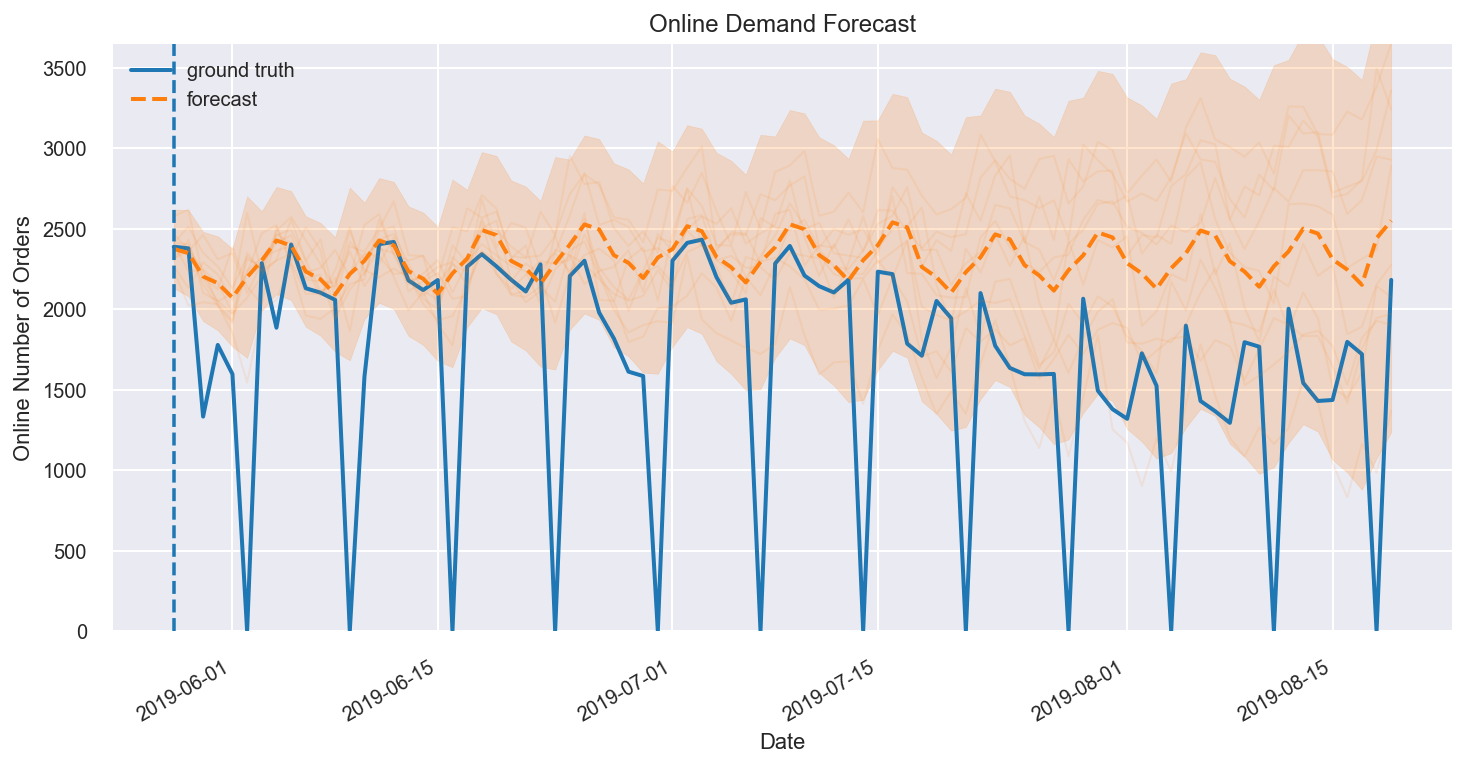

In [146]:
fig, ax = plot_forecast(
    x[-num_forecast_steps:], y.time_series[-num_forecast_steps:],
    demand_forecast_mean, demand_forecast_scale, demand_forecast_samples,
    x_locator=None,
    x_formatter=None,
    title="Online Demand Forecast")

ax.axvline(x[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Online Number of Orders")
ax.set_ylim((0, np.max(demand_forecast_samples)))
ax.set_xlabel("Date")
fig.autofmt_xdate()

# Model decomposition

In [138]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    demand_model,
    observed_time_series=y_train,
    parameter_samples=q_samples_demand_)

forecast_component_dists = sts.decompose_forecast_by_component(
    demand_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

In [139]:
with tf.Session() as sess:
  demand_component_means_, demand_component_stddevs_ = sess.run(
      [{k.name: c.mean() for k, c in component_dists.items()},
       {k.name: c.stddev() for k, c in component_dists.items()}])

  [
      demand_forecast_component_means_,
      demand_forecast_component_stddevs_
  ] = sess.run(
      [{k.name: c.mean() for k, c in forecast_component_dists.items()},
       {k.name: c.stddev() for k, c in forecast_component_dists.items()}])

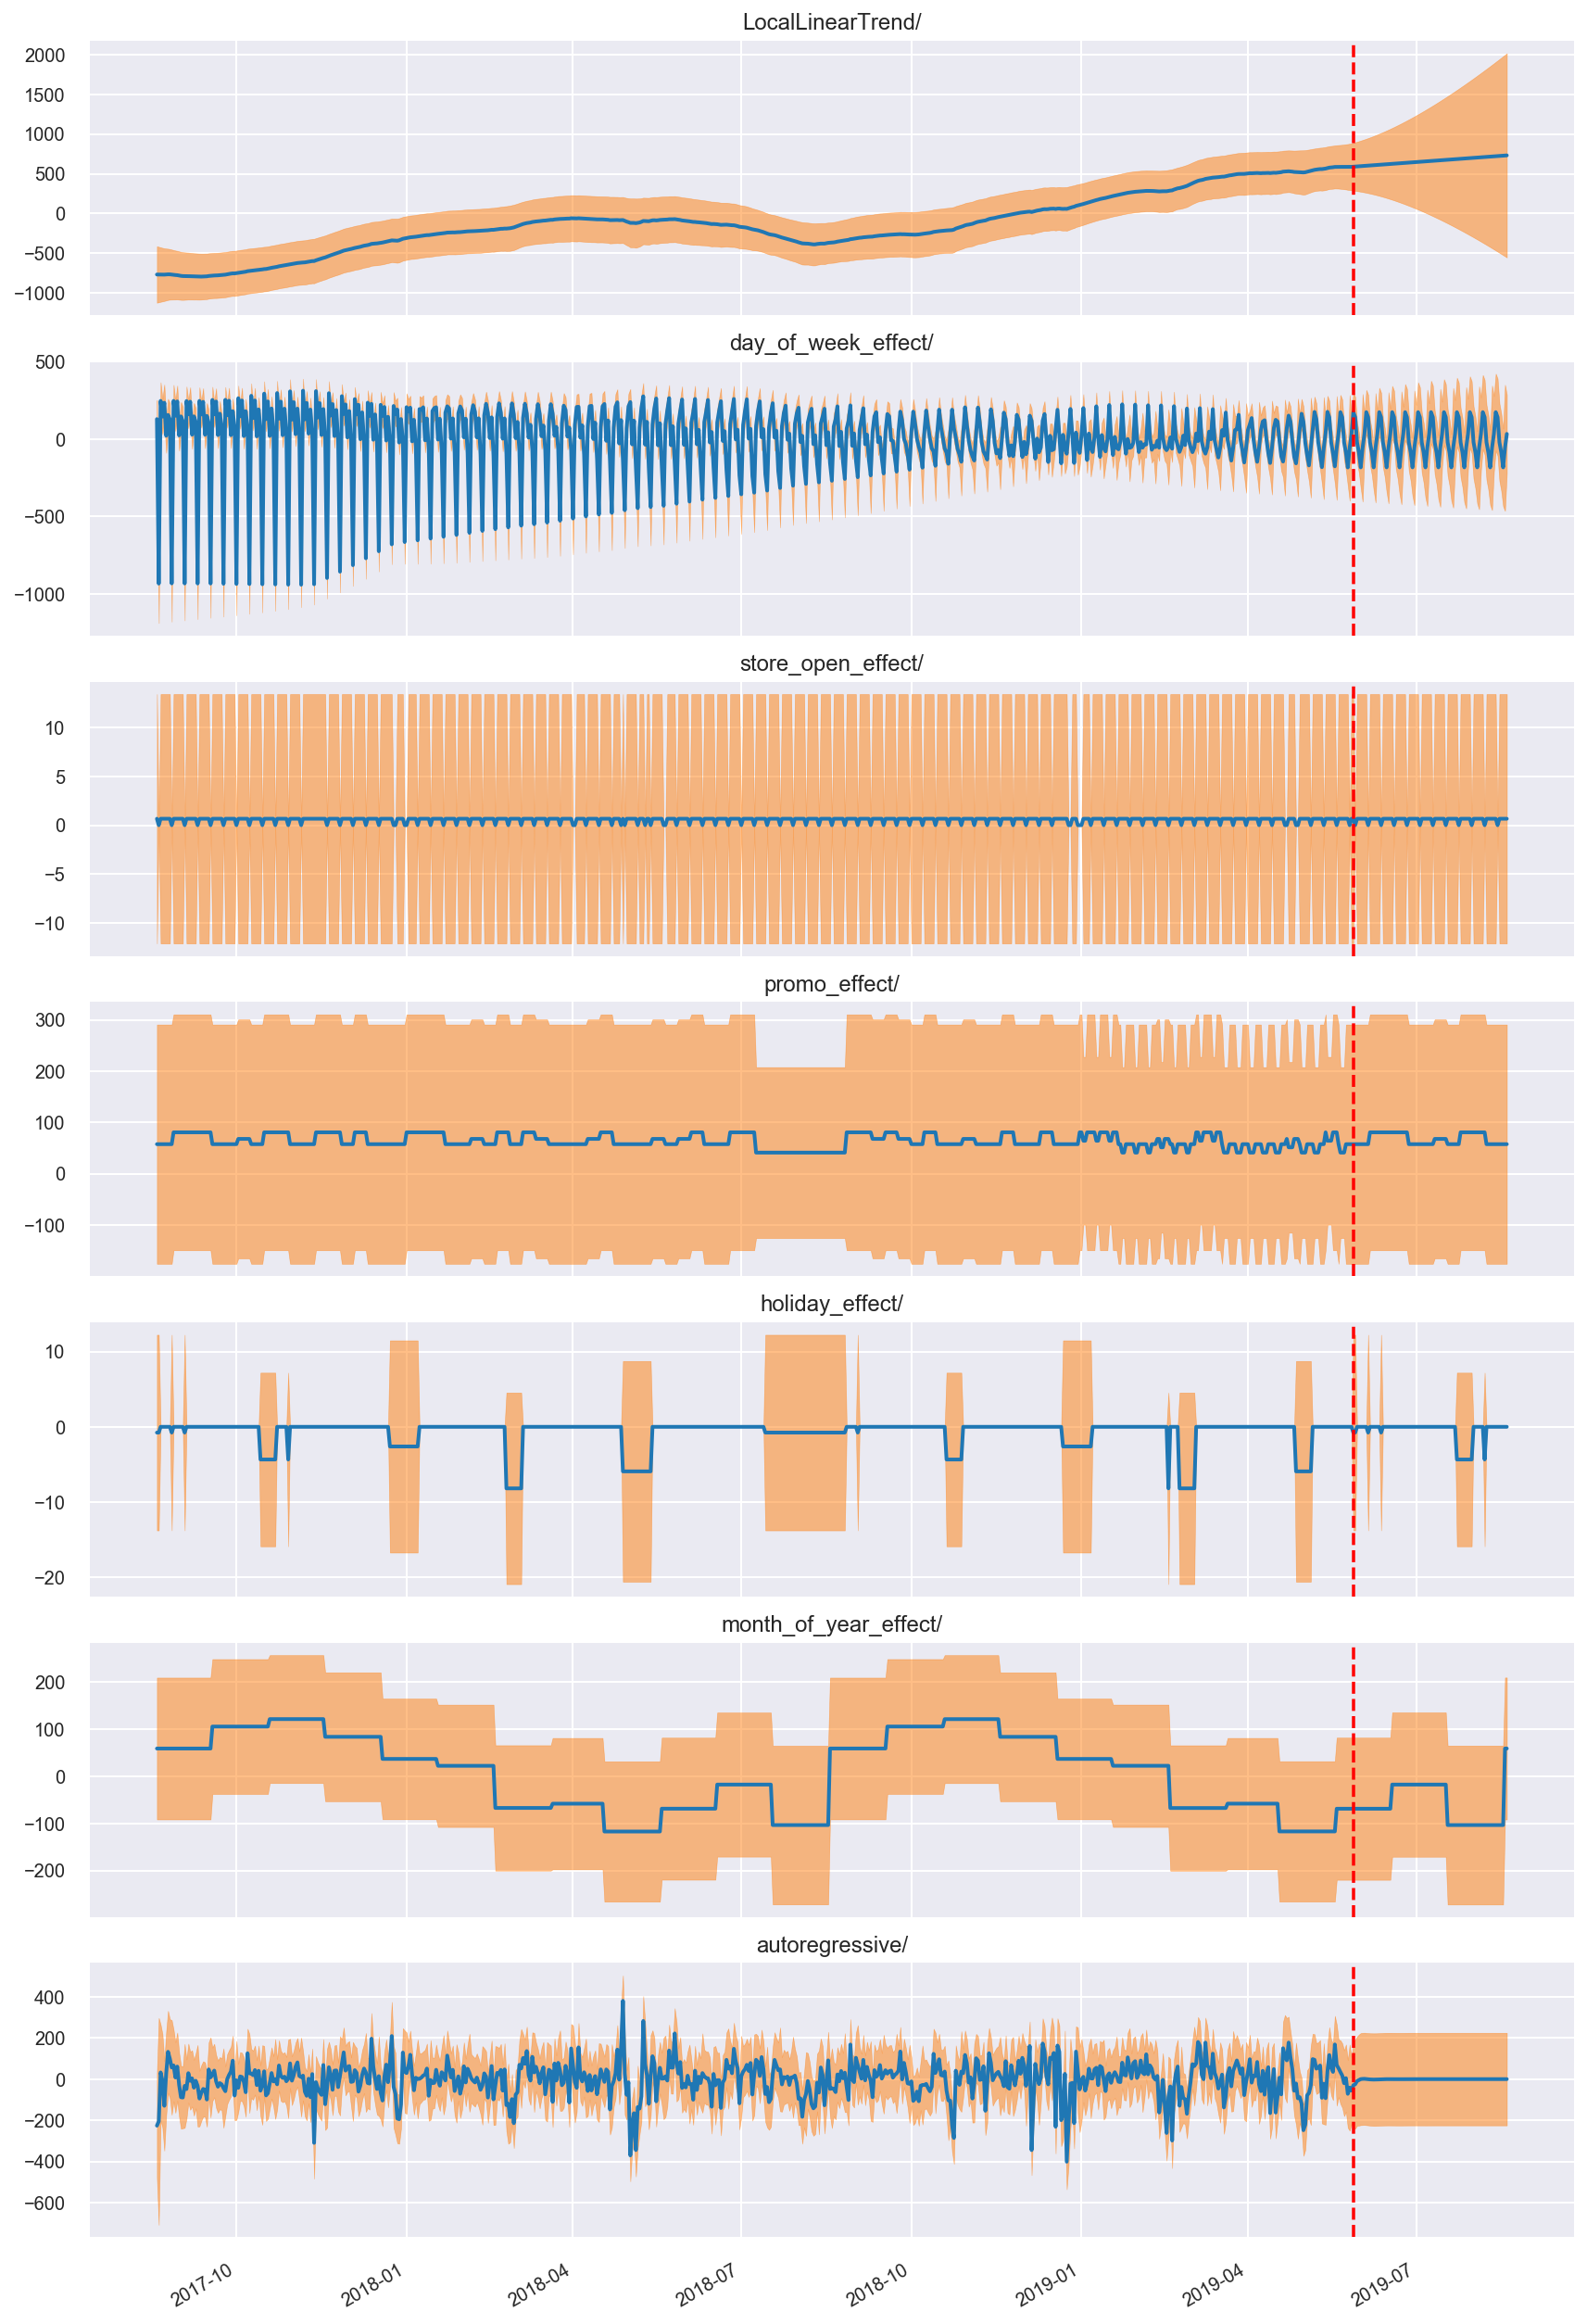

In [140]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  x,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=None, x_formatter=None)
for ax in axes.values():
  ax.axvline(x[-num_forecast_steps], linestyle="--", color='red')

In [141]:
# demand_forecast_mean, demand_forecast_scale, demand_forecast_samples
demand_forecast_mean

array([2373.46176902, 2347.39935417, 2202.51349659, 2160.17338304,
       2070.45843385, 2198.45523414, 2301.43331566, 2426.06051819,
       2394.07613026, 2233.02671446, 2185.15835922, 2090.45064184,
       2217.61895401, 2299.87407224, 2425.95711864, 2395.1947901 ,
       2235.53794175, 2188.42030451, 2094.2535298 , 2221.39967591,
       2313.69162173, 2490.53699587, 2459.26023674, 2299.09955203,
       2251.6181311 , 2157.24070215, 2284.35033139, 2399.79748745,
       2525.53187885, 2494.44796564, 2334.45906988, 2287.09020842,
       2192.75342967, 2319.83042783, 2372.58112216, 2514.65734425,
       2483.44743681, 2323.35164489, 2259.44871502, 2165.08233224,
       2292.17050589, 2384.49911408, 2526.63428079, 2495.48524641,
       2335.43984347, 2271.56739583, 2177.20805513, 2303.51465245,
       2396.58029775, 2538.67691642, 2507.48969549, 2261.42889558,
       2197.53748256, 2102.40539512, 2229.48619596, 2321.80030094,
       2463.91684965, 2432.7491389 , 2272.6881343 , 2208.80499

In [142]:
df_test["Forecast_mean"] = demand_forecast_mean
df_test["Forecast_std"] = demand_forecast_scale

C:\anaconda3\envs\demand\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\anaconda3\envs\demand\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [143]:
df_forecast_output = pd.concat([df_test.reset_index(),
           pd.DataFrame(demand_forecast_samples.transpose(), columns=["Sample_%d" % i for i in range(demand_forecast_samples.shape[0])])],
         axis=1)
df_forecast_output.head()

,index,date_delivery,Nieuwjaarsdag,Paasdag,Koningsdag,Hemelvaartsdag,Pinksterdag,Kerstdag,Zomervakantie,Meivakantie,...,Sample_0,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9
0,83,2019-05-28,0,0,0,0,0,0,0,0,...,2411.430789,2314.412100,2576.417468,2242.804197,2299.713513,2265.795727,2408.962407,2413.763063,2336.011465,2466.327842
1,82,2019-05-29,0,0,0,1,0,0,0,0,...,2511.230741,2359.089283,2617.134869,2020.010347,2428.379483,2131.178211,2235.266822,2401.669246,2370.223757,2370.147267
2,81,2019-05-30,0,0,0,1,0,0,0,0,...,2348.506777,2460.869751,2194.608113,2041.954288,2100.396050,2290.627994,2240.687543,2189.499759,2153.018082,2245.114586
3,80,2019-05-31,0,0,0,1,0,0,0,0,...,2263.894320,2309.097167,2123.424748,2030.580353,2051.212923,2215.191582,2031.945759,2046.856843,2018.475021,2163.344113
4,79,2019-06-01,0,0,0,0,0,0,0,0,...,2127.996780,2346.930062,2384.137993,1851.513914,1966.913722,2057.252019,1929.499168,2097.167829,1913.375191,1973.020927


In [144]:
max(df_train.date_delivery)

Timestamp('2019-05-27 00:00:00')

In [145]:
df_forecast_output.to_csv("../data/processed/tensorflow_sts_forecast.csv")